
This colab provides a walk-through examples for calculating fractal parameters, as described in the following paper:

```
Alabdulmohsin, Ibrahim, Vinh Q. Tran, and Mostafa Dehghani.
"Fractal Patterns May Unravel the Intelligence in Next-Token Prediction."
arXiv preprint arXiv:2402.01825 (2024).
```


In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<a href="https://colab.research.google.com/github/google-research/google-research/blob/master/fractals_language/fractal_patterns_in_language.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [2]:
!nvidia-smi -L  # code was tested with T4
!free -g

GPU 0: NVIDIA RTX A6000 (UUID: GPU-4afe1d35-434c-ab9d-bfeb-c3f7c58047d8)
               total        used        free      shared  buff/cache   available
Mem:              61          23          30           0           7          37
Swap:             63           7          56


In [3]:
!pip install -q datasets transformers

In [1]:
import datasets
import torch
import tqdm.notebook
import transformers

import numpy as np
import sklearn.linear_model
import jax, jax.numpy as jnp

import matplotlib
import matplotlib.pyplot as plt

np.random.seed(2024)

In [2]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cuda:0'

# Utils

In [36]:
# These default values are different in the paper. For illustration purposes
# here, we use only 100 documents. In the paper, we use 1K documents per domain.
# See the docstrings for how to select arguments carefully.

DEFAULT_SCALES = [25, 50, 75, 100, 200, 300]
DEFAULT_SAMPLES_PER_DOC = 100
DEFAULT_EPS = 5e-2


latex_context = {
    'text.usetex': False,
    'mathtext.fontset': 'stix',
    'font.family': 'sans-serif',
    'font.size': 20.0,
    'legend.fontsize': 20.0,
    'axes.labelsize': 20.0,
    'axes.titlesize': 20.0,
    'xtick.labelsize': 20.0,
    'ytick.labelsize': 20.0,
    'axes.axisbelow': True,
}


def power_law_fit(x, y):
  """Fit a power law to the data (x, y)."""
  ones_logx = np.stack([np.ones_like(x), np.log(x)], axis=1)
  logy = np.log(y)
  clf = sklearn.linear_model.LinearRegression(
      fit_intercept=False).fit(ones_logx, logy)
  return clf.coef_[0], clf.coef_[1]  # coeff, exponent


def plot_power_law(x, y,
                   xlabel, ylabel, title='', yscale='',
                   ylim=None, xlim=None, xticks=None, yticks=None):
  """Plot a power law fit to the data (x, y)."""
  if xlim is None:
    minx, maxx = min(x), max(x)
  else:
    minx, maxx = tuple(xlim)

  log_beta, c = power_law_fit(x, y)
  xp = np.linspace(minx, maxx, 100)
  yp = np.exp(log_beta) * np.power(xp, c)

  with matplotlib.rc_context({**latex_context}):
    fig, axes = plt.subplots(1, 1, figsize=(4, 4), constrained_layout=True)

    axes.scatter(x, y, s=200, marker="o")
    axes.plot(xp, yp, 'red')
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xscale('log')
    axes.grid(axis='y')
    axes.set_ylim(ylim)
    axes.set_xlim(xlim)
    if yscale == 'log': axes.set_yscale('log')
    if title: axes.set_title(title)
    if xticks: axes.set_xticks(xticks)
    if yticks: axes.set_yticks(yticks)
  return fig

# Language model
We use GPT2 as an example in this colab demo.

In [56]:
# model_name = 'gpt2'
model_name = "Qwen/Qwen1.5-1.8B"
model = transformers.AutoModelForCausalLM.from_pretrained(model_name).to(device)
tokenizer = transformers.AutoTokenizer.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/1.29k [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [57]:
MAX_LENGTH = 1024  # gpt2 max supported sequence length

# Dataset

In [58]:
from torch.utils.data import Dataset
import json

class ProcessedData(Dataset):
    def __init__(self, file_path:str ):
        super().__init__()
        self.articles = self.get_articles(file_path)

    def get_articles(self, file_path: str):
        articles = []
        # Loop through each file in the markdown folder
        with open(file_path, 'r', encoding='utf-8') as file:
            datas = json.load(file)
            for data in datas:
                articles.append(data)
        return articles

    def __len__(self):
        return len(self.articles)

    def __getitem__(self, idx):
        return self.articles[idx]


In [59]:
ds = datasets.load_dataset("codeparrot/github-code", streaming=True, split="train")

/home/kerjan/miniconda3/envs/hurst/lib/python3.11/site-packages/datasets/load.py:1461: FutureWarning: The repository for codeparrot/github-code contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/codeparrot/github-code
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


In [41]:
processed_ds = ProcessedData('./processed_qa_scientific_papers-zephyr.json')
unprocessed_ds = ProcessedData('./unprocessed_scientific_papers.json')

When calculating fractal parameters, we calculate them over a collection of documents, to ensure we have enough independent samples when estimating, for example, autocorrelations. In the paper, we used 1K documents per domain. For illustration purposes here, we only use 100.

In [61]:

num_documents = 10  #@param = 'int'
it = iter(ds)
unprocessed_tokens = []
while len(unprocessed_tokens) < num_documents:
  b = next(it)
  c = tokenizer.encode(b['code'], return_tensors='pt')
  if c.shape[1] > MAX_LENGTH+1024:
    unprocessed_tokens.append(c[0, 0: MAX_LENGTH])

# Tokenize

torch.Size([2048])


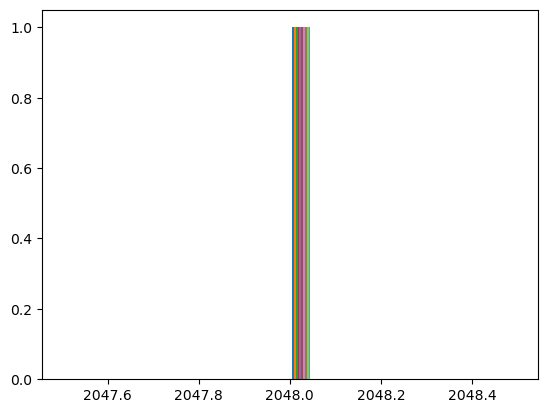

In [62]:
# distribution of document lengths
print(unprocessed_tokens[0].shape)
_ = plt.hist([unprocessed_tokens[i].shape for i in range(len(unprocessed_tokens))], 20)

We only use sufficiently long documents (e.g. > 2K tokens). Later, we drop the leading 128 tokens (warmup) and use only the first 1K tokens (because the second half can contain links, references, etc, not related to the article itself).

# Score
Next, we score all the tokens and convert scores to bits, i.e. we calculate: $-\log p(tokens[i]\;|\; tokens[0:i])$.

In [63]:
all_bits_proc = []
for i in tqdm.notebook.tqdm(range(len(unprocessed_tokens))):
  ts = unprocessed_tokens[i].numpy()
  with torch.no_grad():
    logits = model(torch.tensor(ts)[None].to(device)).logits[0].cpu().numpy()
    # convert logits to probability scores over the vocabulary
    p = jax.nn.log_softmax(logits)
    # convert to bits per token
    indices = jnp.array(list(zip(range(len(ts)), ts))).T
    bits = -p[tuple(indices)]

    all_bits_proc.append(bits.tolist()[128:]) # we drop the first 128 tokens (warmpu)

  0%|          | 0/10 [00:00<?, ?it/s]

In [64]:
all_bits_proc = np.array(all_bits_proc)
print(all_bits_proc.shape)
print(all_bits_proc)

(10, 1920)
[[21.08402061 11.52977371 24.92905807 ... 12.51542377 26.30158424
  18.90480232]
 [14.35843277 18.7371006  18.56622124 ... 14.82937717 22.65999603
  18.50757408]
 [16.98460197 18.6794796  20.20386887 ... 21.83995247 17.13396835
  16.73360634]
 ...
 [21.84819221 16.93042183 20.16947937 ... 10.1052227  17.60646439
  21.58511162]
 [22.93465996 12.49591446 33.88425064 ... 11.61384678 21.42748451
  13.44976807]
 [29.63717651 26.54213142 29.26933289 ... 18.44308853  4.50124168
  22.26797104]]


# Fractal Analysis

## Increment/integral processes

First, let's see how well the model performs. The mean number of bits is the average log-loss.

In [65]:
np.mean(all_bits_proc), np.std(all_bits_proc)

(16.165659378164, 5.787659597699016)

Now, form the increment $x$ and integral $X$ processes. $x$ is basically the sequence of bits after normalization, while $X$ is the integral of $x$.

In [66]:
x_proc = []
X_proc = []

for k in tqdm.notebook.tqdm(range(len(all_bits_proc))):
  mu = np.mean(all_bits_proc[k])
  sigma = np.std(all_bits_proc[k])
  x_proc.append((all_bits_proc[k] - mu) / sigma)
  X_proc.append(np.cumsum(x_proc[-1]))

x_proc = np.array(x_proc)
X_proc = np.array(X_proc)
x_proc.shape, X_proc.shape

  0%|          | 0/10 [00:00<?, ?it/s]

((10, 1920), (10, 1920))

Plot the integral process to see how self-similar it is.

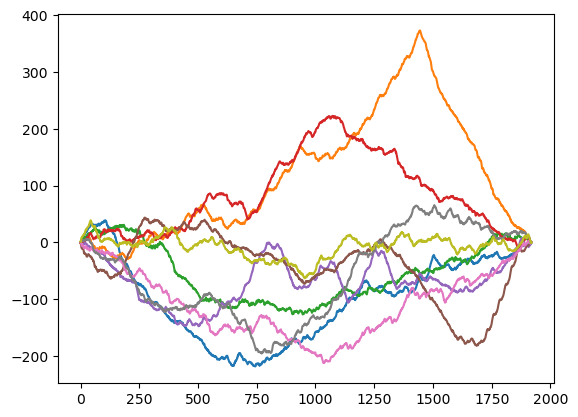

In [67]:
for i in range(0, 9):
    plt.plot(X_proc[i])

## Hurst exponent

In [68]:
def get_hurst_exponent(x,
                       scales=DEFAULT_SCALES,
                       samples_per_doc=DEFAULT_SAMPLES_PER_DOC):
  """Calculate the Hurst exponent.

  Args:
    x: increment process, 1D or 2D array.
    scales: granuality levels. Choose this carefully.
      If it is too large, you will have very few measurements.
      If it is too small, your estimate of the power law relation will be
      unreliable.
    samples_per_doc: number of samples per document. Ideally, this should be
      small and the number of documents should be large.

  Returns:
    H: Hurst exponent.
    sr: rescaled range estimates.
  """
  if x.ndim == 1:
    x = x.reshape((1, -1))
  elif x.ndim > 2:
    raise ValueError('x.ndim must be 1 or 2.')

  # calculate the rescaled range
  sr = []
  for n in scales:
    som = 0
    count = 0
    for i in range(len(x)):  # to get a reliable etimate, many documents are needed
      for _ in range(samples_per_doc):
        offset = np.random.randint(0, len(x[i]) - n)
        y = x[i, offset: n + offset]
        y = y - np.mean(y)
        Y = np.cumsum(y)
        R = max(Y) - min(Y)
        S = np.std(y)
        som += R / S
        count += 1
    sr.append(som / count)
    
  # estimate Hurst exponent
  return power_law_fit(scales, sr)[1], sr

In [71]:
hurst_exponent_proc = []
for _ in tqdm.notebook.tqdm(range(10)):
  articles = np.random.choice(np.arange(len(x_proc)), len(x_proc))  # with replacement
  hurst_exponent_proc.append(get_hurst_exponent(x_proc[articles])[0])

print(np.mean(hurst_exponent_proc), np.std(hurst_exponent_proc))

  0%|          | 0/10 [00:00<?, ?it/s]

0.7793660717247841 0.024089458911382814


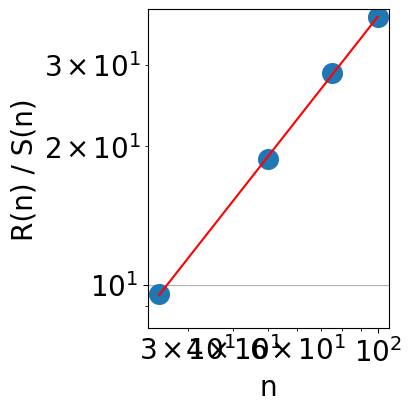

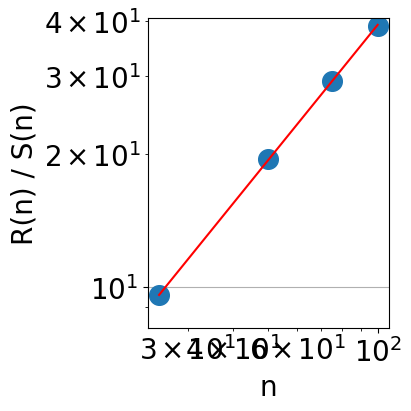

In [178]:
# see the quality of fit
_, y = get_hurst_exponent(X_proc)
_, z = get_hurst_exponent(X_unproc)
fig = plot_power_law(DEFAULT_SCALES,  # because we use default granularity levels
                     y,
                     yscale='log',
                     xlabel='n',
                     ylabel='R(n) / S(n)')
fig = plot_power_law(DEFAULT_SCALES,  # because we use default granularity levels
                     z,
                     yscale='log',
                     xlabel='n',
                     ylabel='R(n) / S(n)')

## Joseph exponent

In [ ]:
def get_self_sim_exponent(X,
                          scales=DEFAULT_SCALES,
                          samples_per_doc=DEFAULT_SAMPLES_PER_DOC,
                          eps=DEFAULT_EPS):
  """Calculate the self-similarity exponent.

  Args:
    X: integral process, 1D or 2D array.
    scales: granuality levels. Choose this carefully.
      If it is too large, you will have very few measurements.
      If it is too small, your estimate of the power law relation will be
      unreliable.
    samples_per_doc: number of samples per document. Ideally, this should be
      small and the number of documents should be large.
    eps: used for calculating peak probability scores. Choose this carefully.
      If eps is too small, probability estimates will be unreliable.
      If eps is too large, it doesn't reflect peak probabiliy at the origin.

  Returns:
    S: self-similarity exponent.
    p0: peak probability estimates.
  """
  if X.ndim == 1:
    X = X.reshape((1, -1))
  elif X.ndim > 2:
    raise ValueError('X.ndim must be 1 or 2.')

  p0 = []
  for n in scales:
    all = []
    for i in (range(len(X))):
      for _ in range(samples_per_doc):
        offset = np.random.randint(0, len(X[i]) - n)
        all.append(X[i][offset + n] - X[i][offset])
    all = np.array(all)
    p0.append(np.mean(np.abs(all) < eps))

  # estimate Holder exponent
  return -power_law_fit(scales, p0)[1], p0

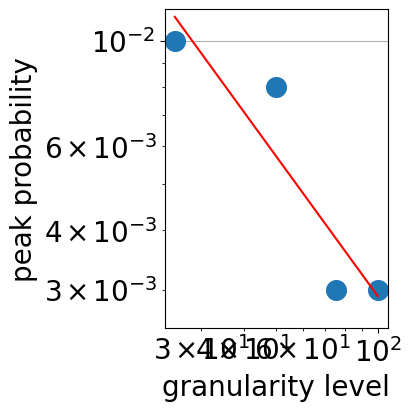

In [ ]:
# see the quality of fit
_, y = get_self_sim_exponent(X_proc)
fig = plot_power_law(DEFAULT_SCALES,  # because we use default granularity levels
                     y,
                     yscale='log',
                     xlabel='granularity level',
                     ylabel='peak probability', )

In [ ]:
# use bootstrapping to estimate uncertainty
np.random.seed(2024)
self_sim_exponent = []
for _ in tqdm.notebook.tqdm(range(10)):
  articles = np.random.choice(np.arange(len(x_proc)), len(x_proc))  # with replacement
  self_sim_exponent.append(get_self_sim_exponent(X_proc[articles])[0])

print(np.mean(self_sim_exponent), np.std(self_sim_exponent))

  0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_2535503/643934331.py:27: RuntimeWarning: divide by zero encountered in log
  logy = np.log(y)


ValueError: Input y contains infinity or a value too large for dtype('float64').

## Self-similarity exponent
Note below that we have a large variance in estimating the self-similarity exponent. This is because: (1) we only use 100 documents (we used 1K in the paper) and (2) the scale level goes up to 300 only (in the paper we used >500). So, if you see a large variance, consider increasing the number of documents and increasing the granularity levels.

In [ ]:
def get_joseph_exponent(x,
                        scales=DEFAULT_SCALES,
                        samples_per_doc=DEFAULT_SAMPLES_PER_DOC):
  """Calculate the Joseph exponent.

  Args:
    x: increment process, 1D or 2D array.
    scales: granuality levels. Choose this carefully.
      If it is too large, you will have very few measurements.
      If it is too small, your estimate of the power law relation will be
      unreliable.
    samples_per_doc: number of samples per document. Ideally, this should be
      small and the number of documents should be large.

  Returns:
    J: Joseph exponent.
    sigmas: standard deviations estimate.
  """
  if x.ndim == 1:
    x = x.reshape((1, -1))
  elif x.ndim > 2:
    raise ValueError('x.ndim must be 1 or 2.')

  sigmas = []
  v = []
  for n in scales:
    for i in range(len(x)):
      for _ in range(samples_per_doc):
        offset = np.random.randint(0, len(x[i]) - n)
        v.extend([X_proc[i][offset + n] - X_proc[i][offset]])
    sigmas.append(np.std(v))

  # estimate Joseph exponent
  return power_law_fit(scales, sigmas)[1], sigmas

In [ ]:
joseph_exponent = []
for _ in tqdm.notebook.tqdm(range(10)):
  articles = np.random.choice(np.arange(len(x_proc)), len(x_proc))  # with replacement
  joseph_exponent.append(get_joseph_exponent(x_proc)[0])

print(np.mean(joseph_exponent), np.std(joseph_exponent))

  0%|          | 0/10 [00:00<?, ?it/s]

0.35772080370919374 0.002647717654797778


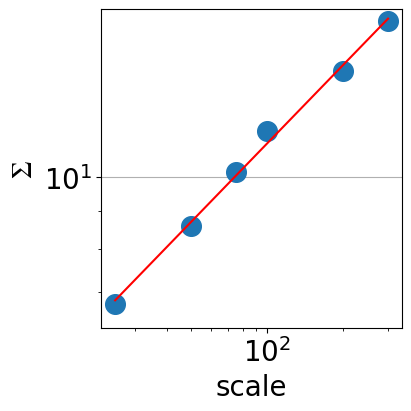

In [ ]:
# see the quality of fit
_, y = get_joseph_exponent(X_proc)
fig = plot_power_law(DEFAULT_SCALES,  # because we use default granularity levels
                     y,
                     yscale='log',
                     xlabel='scale',
                     ylabel='$\Sigma$')